In [41]:
using DataFrames, CSV
using LinearAlgebra, Random, Printf, StatsBase, CategoricalArrays
using Plots, StatsPlots, GRUtils
using Distributions
using Gurobi, JuMP

In [42]:
# Data
data = Matrix(DataFrame(CSV.File("../data/demand.csv")));

# Constants
N = round(Int, (size(data)[1] - 2) / 2)    # number of trips
K = 3 ;                                    # number of shuttles

# Splitting the data into sublists
q = data[1:2*N+2, 4];
d = data[1:2*N+2, 5];
e = data[1:2*N+2, 7];
l = data[1:2*N+2, 8];

#### The cost matrix

We need to compute the cost matrix t[i,j]. For the moment, we know the cost matrix t[i,j] where i and j are origin-destination pairs. As a recall, we have selected 19 possible origins and 45 possible destinations. As our model here includes 99 trips, our current formulation gives: t[i,j] could be t[67,97] which of course leads to an error. Therefore, we should find a way to compute the cost matrix t[i,j] for each trip.

In [43]:
data

30×9 Matrix{Any}:
  0  42.3638  -71.0886   0  0.0  …  "Depot"
  1  42.3551  -71.1032   1  0.5     "Westgate Apartments"
  2  42.36    -71.0884   1  0.5     "East Campus"
  3  42.3553  -71.1006   1  0.5     "New House"
  4  42.3621  -71.0854   1  0.5     "Graduate Tower"
  5  42.3592  -71.0976   1  0.5  …  "New Vassar"
  6  42.3556  -71.0996   1  0.5     "MacGregor House"
  7  42.355   -71.1019   1  0.5     "Next House"
  8  42.3544  -71.1035   2  0.5     "Tang Hall"
  9  42.3599  -71.102    1  0.5     "Sidney-Pacific"
 10  42.3589  -71.1011   1  0.5  …  "Ashdown House"
 11  42.3601  -71.098    1  0.5     "Edgerton House"
 12  42.3551  -71.1032   1  0.5     "Westgate Apartments"
  ⋮                              ⋱  
  4  42.3588  -71.0898  -1  0.5     "MIT Department of Mathematics"
  5  42.3601  -71.098   -1  0.5     "Edgerton House"
  6  42.3544  -71.1068  -1  0.5  …  "W98 at Vassar St"
  7  42.3586  -71.0877  -1  0.5     "MIT Sailing Pavilion"
  8  42.3585  -71.094   -2  0.5     "MIT 

In [44]:
# Use this cost later to load costs from BingsMap. For now, we will simply use the euclidian distance as shown below.
driving_times = DataFrame(CSV.File("../data/OR_Full_Times.csv"));
origins_names = driving_times[:,1]
destinations_names = names(driving_times)[2:end];
driving_times = Matrix(driving_times)[:,2:end];

# Let's construct the matrix t[i,j]
t = zeros(2*N+2, 2*N+2)

# Create a dictionary
origin_dict = Dict(zip(origins_names,1:length(origins_names)));
destination_dict = Dict(zip(destinations_names,1:length(destinations_names)));


for i in 1:2*N+2
    for j in 1:2*N+2

        orr = data[i,9]
        des = data[j,9]

        # find the index of orr in origins_names
        # orr_index = findfirst(x -> x == orr, origins_names)
        # des_index = findfirst(x -> x == des, destinations_names)

        orr_index = origin_dict[orr]
        des_index = destination_dict[des]

        t[i,j] = driving_times[orr_index, des_index]
    end 
end 

c = t ; #let's consider in this initial model that the travel cost and the time and equivalent. 

### The model

In [45]:
model = Model(Gurobi.Optimizer)

V =  1:2*N+2                    # all vertices
P = 2:N+1                       # pick up vertices
D = N+2:2*N+1                   # drop off vertices
PUD = 2:2*N+1                   # all pick up and drop off vertices together (all vertices except depot)
Penalty = 100                         # Penalty 


T = fill(100000, K)                # maximum duration of route k
L = 10000      
Q_max = 50                   # maximum time of a drive
Q = fill(Q_max, K)                # capacity of each car

# Variables
@variable(model, x[1:2*N+2, 1:2*N+2, 1:K] >= 0, Bin)   # x[i, j, k] = 1 if we go from node i to node j with vehicle k.
@variable(model, w[1:2*N+2, 1:K] >= 0, Int)            # w[i,k] load of vehicle k when arriving upon leaving vertex i
@variable(model, r[1:N] >= 0)                          # r[i,k] travel time of passenger i (Note that passenger i is identified by) the vertex i+1
@variable(model, u[1:2*N+2, 1:K] >= 0)                 # u[i,k] time as which the vertex i is served by vehicle k
@variable(model, a[1:2*N+2, 1:K] >= 0)                 # a[i,k] = max{u[i,k] - l[i], 0} (waiting time in excess for l[i] at vertex i for vehicle k)

#############  Constraints  #############

# only one car can bring passenger {i, i+N} to its final destination.
@constraint(model, [i in P], sum(sum(x[i, j, k] for j in V) for k = 1:K) == 1)

# each vehicle starts at the depot
@constraint(model, [k = 1:K], sum(x[1, j, k] for j in V) == 1)

# each vehicle ends at the depot
@constraint(model, [k = 1:K], sum(x[i, 2*N+2, k] for i in V) == 1)

# each passenger is picked and droped by the same car
@constraint(model, [i in P, k = 1:K], sum(x[i, j, k] for j in V) - sum(x[i+N, j, k] for j in V) == 0)

# vehicle k follows the edges sequentially
@constraint(model, [i in PUD, k = 1:K], sum(x[j, i, k] for j in V) - sum(x[i, j, k] for j in V) == 0)

# PREVIOUS the time served of vertex i
# @constraint(model, [i in V, j in V, k = 1:K], u[j, k] >= (u[i, k] + d[i] + t[i, j]) * x[i, j, k])

# BIG M LINEARIZATION
M = zeros(2*N+2, 2*N+2)
for i in 1:2*N+2
    for j in 1:2*N+2
        M[i,j] = max(0, l[i] + d[i] + t[i,j] - e[j])
    end
end
@constraint(model, [i in V, j in V, k = 1:K], u[j, k] >= u[i, k] + d[i] + t[i, j] - M[i,j]*(1-x[i, j, k]))

# updating the load of the vehicle
# @constraint(model, [i in V, j in V, k = 1:K], w[j, k] >= (w[i, k] + q[j]) * x[i, j, k])

# BIG W LINEARIZATION
W = zeros(2*N+2, 2*N+2)
for i in 1:2*N+2
    for j in 1:2*N+2
        W[i,j] = min(Q_max, Q_max + q[i])
    end
end
@constraint(model, [i in V, j in V, k = 1:K], w[j, k] >= w[i, k] + q[j] - W[i,j]*(1-x[i, j, k]))

# updating the travel time of passenger i
@constraint(model, [i in P, k = 1:K], r[i-1] == u[N+i, k] - (u[i, k] + d[i]))

# respecting the total length of a trip
@constraint(model, [k = 1:K], u[2*N+2,k] - u[1,k] >= 0) # NEW
@constraint(model, [k = 1:K], u[2*N+2,k] - u[1,k] <= T[k])

# respecting travel window of passenger i
@constraint(model, [i in V, k = 1:K], e[i] <= u[i,k])
#@constraint(model, [i in V, k = 1:K], u[i,k] <= l[i])
@constraint(model, [i in V, k = 1:K], a[i,k] >= u[i,k] - l[i])

# respecting travel window of passenger i
@constraint(model, [i in P], t[i,i+N] <= r[i-1])
@constraint(model, [i in P], r[i-1] <= L)

# respecting each car's capacity
@constraint(model, [i in V, k = 1:K], max(0, q[i]) <= w[i, k])
@constraint(model, [i in V, k = 1:K], w[i, k] <= min(Q[k], Q[k] + q[i]))

# objective
@objective(model, Min, sum(sum(sum(c[i, j] * x[i, j, k] for k = 1:K) for i in V) for j in V) + Penalty * sum(sum(a[i,k] for k=1:K) for i in V));

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-17


In [46]:
optimize!(model)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 5982 rows, 2984 columns and 24763 nonzeros
Model fingerprint: 0x6e8a7cde
Variable types: 194 continuous, 2790 integer (2700 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+03]
  Objective range  [1e-01, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+05]
Presolve removed 616 rows and 138 columns
Presolve time: 0.05s
Presolved: 5366 rows, 2846 columns, 29249 nonzeros
Variable types: 194 continuous, 2652 integer (2562 binary)

Root relaxation: objective 1.853320e+01, 179 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   18.53320    0   56          -   18.53320      -     -    0s
     0     0   21.34731    0  121          -   21.34731   

In [47]:
x_values = value.(x)

30×30×3 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0 

In [48]:
u_values = value.(u)

30×3 Matrix{Float64}:
   0.0       0.0       0.0
  84.2089   84.2089   84.2089
 117.455   120.502   117.455
 103.656   103.656   103.656
  96.9189   96.9189   96.9189
  82.7521   87.4522   82.7521
  66.5832   66.5832   66.5832
 139.444   128.499   128.499
 109.89    109.89    109.89
  73.1039   83.6022   73.1039
  78.3006   84.9022   78.3006
 106.79    115.819   106.79
 104.973    96.8313   96.8313
   ⋮                 
 111.919   111.919   111.919
  86.4047   91.1048   86.4047
  86.2256   86.2256   86.2256
 154.444   143.499   143.499
 126.813   126.813   126.813
  91.3372  101.836    91.3372
  93.3006   99.9022   93.3006
 121.79    130.819   121.79
 123.813   115.671   115.671
 149.46    149.46    149.46
 148.027   148.027   148.027
 160.244   140.652     0.0

In [49]:
r_values = value.(r)

14-element Vector{Float64}:
 14.5
 14.5
 29.370761578227103
 14.5
  3.1526292277995225
 19.142491436488015
 14.5
 16.42352085915084
 17.7333
 14.5
 14.5
 18.34018047634649
 28.89718110188062
 14.5

In [50]:
w_values = round.(Int, value.(w))

30×3 Matrix{Int64}:
 0   0   0
 2   1   1
 1   2   1
 1  50   1
 1   3   1
 1   3   1
 1   1   1
 3  50   1
 4   2   2
 1   1   1
 1   2  50
 1   1   1
 2   1   1
 ⋮      
 0   0   0
 0   2   0
 1   0   0
 0  49   0
 2   0   0
 0   1   0
 0   2   0
 0   1   0
 4   0   0
 1   2   0
 2  49   1
 0   0   0

In [51]:
function plot_route(df, x_val, w_val, plot_size)
    
    # df: dataframe containing all the input data:
    #     column 1: Passenger ID
    #     column 2: PickUp/DropOff Pos_x
    #     column 3: PickUp/DropOff Pos_y
    #     column 4: load (number of passengers to embark)
    #     column 5: service duration (embark time)
    #     column 6: preferred pick up time
    #     column 7: lower bound of pick up time
    #     column 8: upper bound of pick up time

    # car_nbr: the vehicle number to plot

    # x_val: the values of x
    
    #constants 
    N = round(Int,(size(df)[1]-2)/2)

    cars_used = findall([sum(x_val[:,:,i]) for i=1:size(x_val)[3]] .> 2)
    
    println("Number of cars used: $(length(cars_used))")
    println("The car(s) used are(is): ", cars_used)

    plots = []

    for ii in 1:length(cars_used)

        car = cars_used[ii]

        p = Plots.plot(titlefont=font(20, "Computer Modern"), 
            title="Result for different shutle number: $car",  
            legend = :outertopright,
            format=:png)
        
        customers_deserved = findall(x_val[:, :, car] .== 1)
        pickup_deserved = [elem[1] for elem in customers_deserved] 
        pickup_deserved = [elem for elem in pickup_deserved if elem <= N+1]  

        dropoff_deserved = [elem[1] for elem in customers_deserved] 
        dropoff_deserved = [elem for elem in dropoff_deserved if elem > N+1] 

        # plot the depot
        Plots.scatter!(p, [df[1, 2]], [df[2*N+2, 3]], 
            color="black", 
            markersize=5, 
            labels="Depot", 
            size = (plot_size[1], plot_size[2]),
            )

        # plot all nodes
        for i in pickup_deserved
            pass_ID = round(Integer, df[i,1])

            Plots.scatter!(p, [df[i, 2]], [df[i, 3]],
                color="lightgreen", 
                xlabel="x", ylabel="y",
                labels="PickUp ID: $pass_ID - $(df[i,4]) passenger(s)",  
                annotations = (df[i, 2], df[i, 3], Plots.text("  Pick:$pass_ID", :left, pointsize=10)),
                format=:png,
                markersize=5)
        end

        # plot all nodes
        for i in dropoff_deserved
            pass_ID = round(Integer, df[i,1])

            Plots.scatter!(p, [df[i, 2]], [df[i, 3]],
                color="red", 
                xlabel="x", ylabel="y",
                labels="DropOff ID: $pass_ID - $(df[i,4]) passenger(s)",  
                annotations = (df[i, 2], df[i, 3], Plots.text("  Drop:$pass_ID", :left, pointsize=10)),
                format=:png,
                markersize=5)
        end




        colors = ["black", "red", "green", "blue", "pink"]
        vals = findall(x_val[:, :, car] .== 1)
        for elem in vals
            i, j = elem[1], elem[2]
            Plots.plot!(p, [df[i, 2], df[j, 2]], [df[i, 3], df[j, 3]], color=colors[car], labels="", textposition="bottom left", linewidth=1, arrow=true, arrowwidth=3, format=:png)
        end

        # plot the depot
        Plots.scatter!(p, [df[1, 2]], [df[2*N+2, 3]], 
            titlefont=font(20, "Computer Modern"), 
            color="black", 
            markersize=5, 
            labels="Depot", 
            format=:png)

        vals = findall(x_val[:, :, car] .== 1)
        # extract first element of cartesian index
        vals = [elem[1]-1 for elem in vals]        
        # get the values lower than N+1
        vals = [elem for elem in vals if elem < N+1]  
        # order the list vals
        vals = sort(vals)
        println("The shuttle $car served customers: ", vals)
        push!(plots, p)
    end
    return plots
end



plot_route (generic function with 1 method)

In [52]:
x_values = round.(Int, value.(x))
w_values = round.(Int, value.(w))
plots = plot_route(data, x_values, w_values, [1100, 650]) ;

Number of cars used: 2
The car(s) used are(is): [1, 2]
The shuttle 1 served customers: [0, 1, 3, 6, 7, 8, 12, 13, 14]
The shuttle 2 served customers: [0, 2, 4, 5, 9, 10, 11]


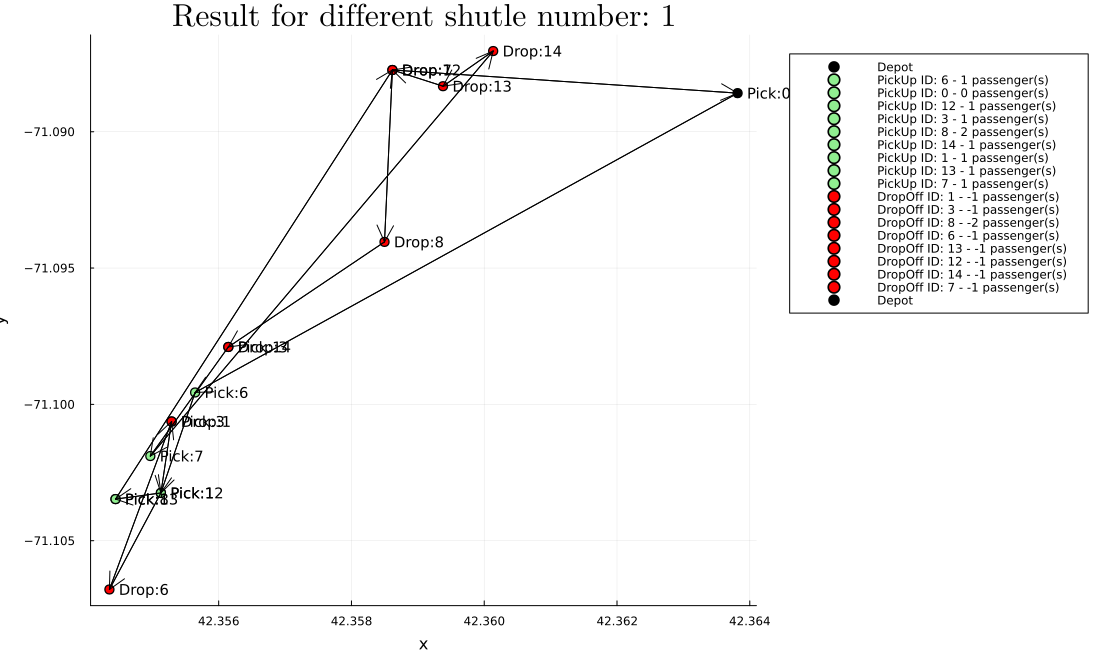

In [53]:
plots[1]

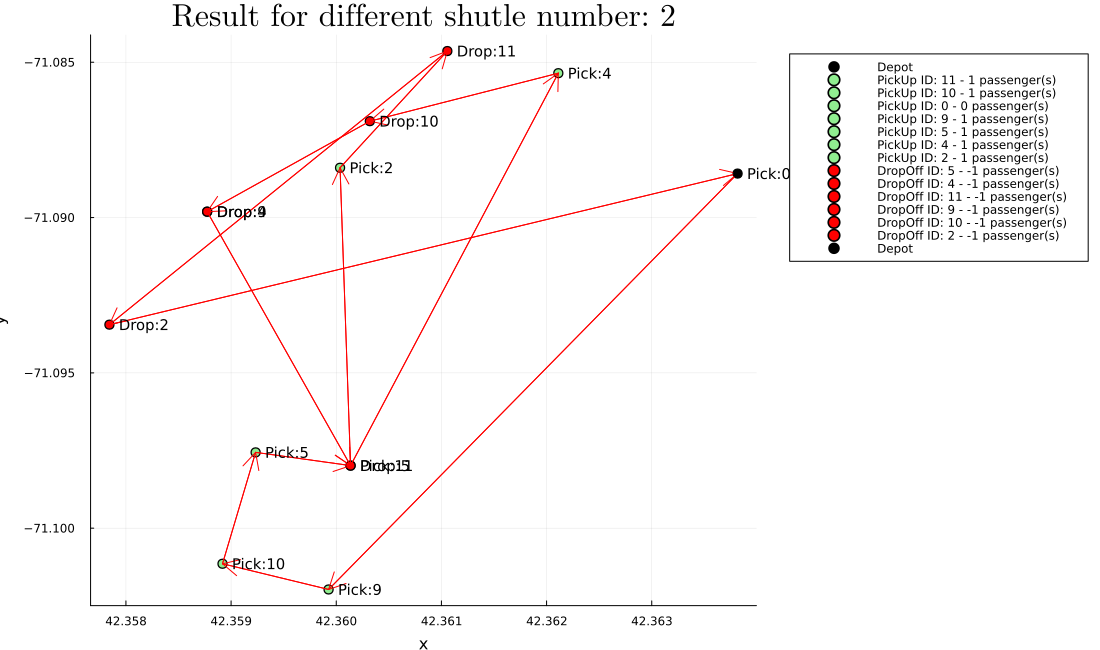

In [54]:
plots[2]

In [55]:
plots[3]

LoadError: BoundsError: attempt to access 2-element Vector{Any} at index [3]

In [ ]:
# get the indices all the elements equal to 1 in x_values
vals = [findall(x_values[:, :, i] .== 1)[1] for i=1:K]
vals

3-element Vector{CartesianIndex{2}}:
 CartesianIndex(11, 4)
 CartesianIndex(1, 9)
 CartesianIndex(25, 2)